# Phase 2 - Exploratory analysis
### Authors: Karolina Skrypova(50%), Oleh Fedunchyk(50%)

##Importing libraries

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

## Loading the data

In [57]:
connections_data = pd.read_csv('https://raw.githubusercontent.com/myrres0/IAU-2024/main/dataset-120/connections.csv', sep='\t')
devices_data = pd.read_csv('https://raw.githubusercontent.com/myrres0/IAU-2024/main/dataset-120/devices.csv', sep='\t')
processes_data = pd.read_csv('https://raw.githubusercontent.com/myrres0/IAU-2024/main/dataset-120/processes.csv', sep='\t')

##Merging datasets

Із попередньої фази, після аналізу кожного датасету ми дійшли до висновку, що датасел із профілями, ми не будемо включати до об'єднаного датасету оскільки він мав багато проблем, зокрема такі як велика кількість значень, різні формати даних, дублікаучі значення атрибутів як `"user_id"` та `"imei"`, що просто ускладнює з'єднання. Також даний датасет не мав ніяких важливих атрибутів, які ще й би можна було закодувати у числовй формат, щоб допомогли нам у предикціїї щначення атрибуту `"mwra"`.

Також у минулій фазі ми помітили, що 2 датасети, процеси і коннекшин можна з'єднати оскільки вони логічно пов'язані і мають декілька спільних атрибутів, які є спільними для них обох:

In [58]:
connections_data['ts'].equals(processes_data['ts']) and connections_data['mwra'].equals(processes_data['mwra']) and connections_data['imei'].equals(processes_data['imei'])

True

In [59]:
merged_data = pd.merge(processes_data, connections_data).drop_duplicates()

Що ж стосується датасету девайсів, то він має декілька атрибутів які стосуються локації, які ми б могли спробувати з'єднати.

###З'єднання з датасетом пристроїв
Давайте також перевіримо чи можемо ми з'єднати ще датасет пристроїв, але як ми пам'ятаємо з фази 1 в цьому датасеті дуже багато дублікатів `"imei"` що може ускладнити нам з'єднування, оскільки якщо в таблиці процесів/коннекшинів буде `"imei"`, яке не буде в таблиці девайсів ми можемо отримати нульові значення і при чисті просто втратити цю інформацію, тому перед тим як це зробити варто це перевірити:

In [60]:
devices_data = devices_data.dropna()
df_unique = devices_data.drop_duplicates(subset=['imei'], keep='first')
df_unique.shape[0]

500

In [61]:
result = pd.merge(df_unique, processes_data, on='imei', how='right')
result.shape[0]

15145

In [62]:
result.dropna()
result.shape[0]

15145

Як ми бачимо після мерджу ми не втратили жодної інформації, тобто для кожного рядка в коонекшинах є відповідний девайс, тому можемо спокійно мерджувати датасет девайсів до спільних даних:

In [63]:
merged_data = pd.merge(df_unique, merged_data, on='imei', how='right')
merged_data.shape[0]

14965

Також чатиною датасету девайсів є атрибут `"location"`, який можна розділити на колонки `"continent"` та `"city"`:

In [64]:
merged_data[['continent', 'city']] = merged_data['location'].str.split('/', expand=True, n=1).apply(lambda x: x.tolist() if len(x.dropna()) > 1 else [x[0], None], axis=1, result_type='expand')
merged_data = merged_data.drop(['location'], axis=1)

##Кодування нечислових атрибутів


У цьому розділі ми закодуємо нечислові атрибути для того щоб їх ми надалі могли використовувати для аналізу.

Давайте глянемо які саме атрибути потрібно закодувати:

In [65]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14965 entries, 0 to 14964
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   latitude                    14965 non-null  float64
 1   longitude                   14965 non-null  float64
 2   store_name                  14965 non-null  object 
 3   code                        14965 non-null  object 
 4   imei                        14965 non-null  int64  
 5   ts                          14965 non-null  object 
 6   mwra                        14965 non-null  float64
 7   p.android.packageinstaller  14965 non-null  float64
 8   p.system                    14965 non-null  float64
 9   p.android.externalstorage   14965 non-null  float64
 10  p.android.documentsui       14965 non-null  float64
 11  p.android.gm                14965 non-null  float64
 12  p.android.settings          14965 non-null  float64
 13  p.android.chrome            149

Як ми бачимо більшість атрибутів є вже у числовому форматі, і лише деякі з них не є, а саме:

- store_name
- code
- imei
- ts
- continent
- city

Проте такі атрибути як:

- store_name
- code
- city

мають велику варіацію, що буде складно мапувати, та й не матиме великого значення.

`"imei"` є ж просто ід девайсу, тому вона також уже не має для нас значення.

Тому ці атрибути ми просто видалимо.

In [66]:
merged_data = merged_data.drop(['store_name', 'city','imei'], axis=1)

Атрибути `"continent"` та `"ts"` ми ж все ж перетворимо у числові значення.

###Кодування континентів

In [67]:
continent_mapping = {
    'Asia': 1,
    'America': 2,
    'Europe': 3,
    'Africa': 4,
    'Australia': 5,
    'Indian': 6,
    'Pacific': 7
}

merged_data['continent'] = merged_data['continent'].map(continent_mapping)

In [68]:
merged_data['continent'].value_counts()

,count
continent,
1,4621
2,4176
3,4074
4,1759
5,163
6,106
7,66


Як ми тепер бачимо у нас є нові числові значення.

###Перетворення таймстампів

In [69]:
merged_data['ts'] = pd.to_datetime(merged_data['ts'], format='%Y-%m-%d %H:%M:%S')

merged_data['year'] = merged_data['ts'].dt.year
merged_data['month'] = merged_data['ts'].dt.month
merged_data['day'] = merged_data['ts'].dt.day
merged_data['hour'] = merged_data['ts'].dt.hour
merged_data['minute'] = merged_data['ts'].dt.minute
merged_data['second'] = merged_data['ts'].dt.second

merged_data = merged_data.drop(['ts'], axis=1)
merged_data.head()

,latitude,longitude,code,mwra,p.android.packageinstaller,p.system,p.android.externalstorage,p.android.documentsui,p.android.gm,p.android.settings,...,c.UCMobile.x86,c.android.vending,c.raider,continent,year,month,day,hour,minute,second
0,-3.14306,-58.44417,BR,1.0,7.65899,6.85726,9.87991,12.31537,9.41551,14.14158,...,48.16608,29.46806,62.29823,2,2018,5,5,10,0,0
1,7.50251,5.06258,NG,0.0,7.78225,6.94608,12.03426,13.36483,9.93635,17.04880,...,34.35584,27.40876,58.79877,4,2018,5,5,10,1,0
2,29.22254,79.52860,IN,0.0,13.08195,9.42838,9.35317,5.99089,11.56038,8.67312,...,52.57066,42.52979,14.00816,1,2018,5,5,10,2,0
3,51.16800,7.97300,DE,0.0,6.11318,12.85907,13.96686,5.57127,8.51068,12.03603,...,43.63141,78.21635,85.93087,3,2018,5,5,10,3,0
4,7.50251,5.06258,NG,1.0,8.46230,9.76227,10.11992,11.76912,14.38693,9.72909,...,34.24340,68.61573,3.01488,4,2018,5,5,10,4,0


In [70]:
merged_data[['year', 'month','second']].value_counts()

,,,count
year,month,second,
2018,5,0,14965


Як ми можемо бачити `year,	month,	second` мають фіксовані значення тому ми їх теж видалимо.

##Розподіл даних

In [71]:
merged_data = merged_data.drop(['year', 'month','second'], axis=1)

In [78]:
train_data, test_data = train_test_split(merged_data, test_size=0.25)
print('Training sample contains: '+ str(len(train_data))+' records')
print('Test sample contains: '+ str(len(test_data))+' records')
train_data.to_csv('train_data_before.csv')
test_data.to_csv('test_data_before.csv')

Training sample contains: 10095 records
Test sample contains: 3365 records


##Missing values

Як уже ми згадували в попередній фазі 2 датасети процесів і коннекшинів, взагалі не мали жодний Missing values, а датасет дивайсів мав лише 1 Missing value, що і так не потрапило до об'єднаного датасету.

In [72]:
train_data.isnull().sum()

,0
latitude,0
longitude,0
code,0
mwra,0
p.android.packageinstaller,0
p.system,0
p.android.externalstorage,0
p.android.documentsui,0
p.android.gm,0
p.android.settings,0


##Outliers

In [73]:
def remove_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    cleaned_column = column.copy()
    cleaned_column[(cleaned_column < lower_bound) | (cleaned_column > upper_bound)] = pd.NA

    return cleaned_column

In [74]:
attributes_to_clean = ['p.android.packageinstaller', 'p.system',
       'p.android.externalstorage', 'p.android.documentsui', 'p.android.gm',
       'p.android.settings', 'p.android.chrome',
       'p.inputmethod.latin', 'p.android.gms', 'c.katana', 'c.dogalize', 'c.android.gm',
       'c.android.chrome', 'c.android.youtube', 'c.UCMobile.intl',
       'c.updateassist', 'c.UCMobile.x86']

clean_data = train_data[attributes_to_clean].apply(remove_outliers)

In [75]:
for i in range(3):
  clean_data = clean_data.apply(remove_outliers)

<Axes: >

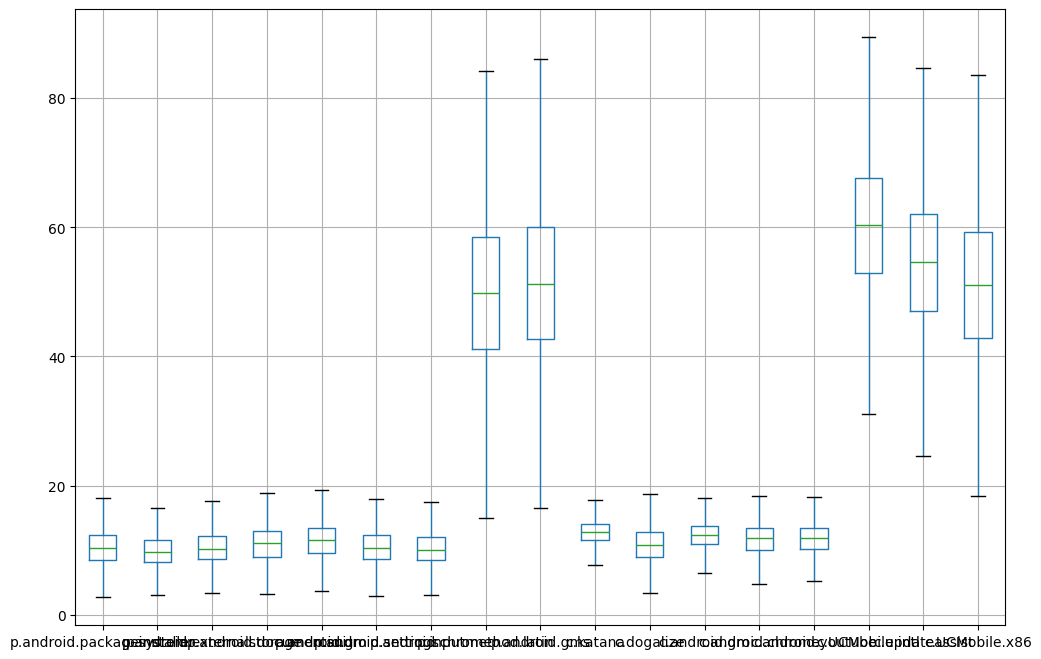

In [76]:
clean_data.boxplot(figsize=(12, 8))

In [77]:
train_data[attributes_to_clean] = clean_data
train_data = train_data.dropna()

Як ми з'ясували в попередній фазі, що найкращим методом, з усіма випробуваними нами, для того щоб зберегти нормальні дистрибуції атрибутів є саме видалення аутлаєрів.

Тож як ми з'ясували після 4 ітерацій чищення, ми позбудемося всіх аутлаєрів.

##Кореляції

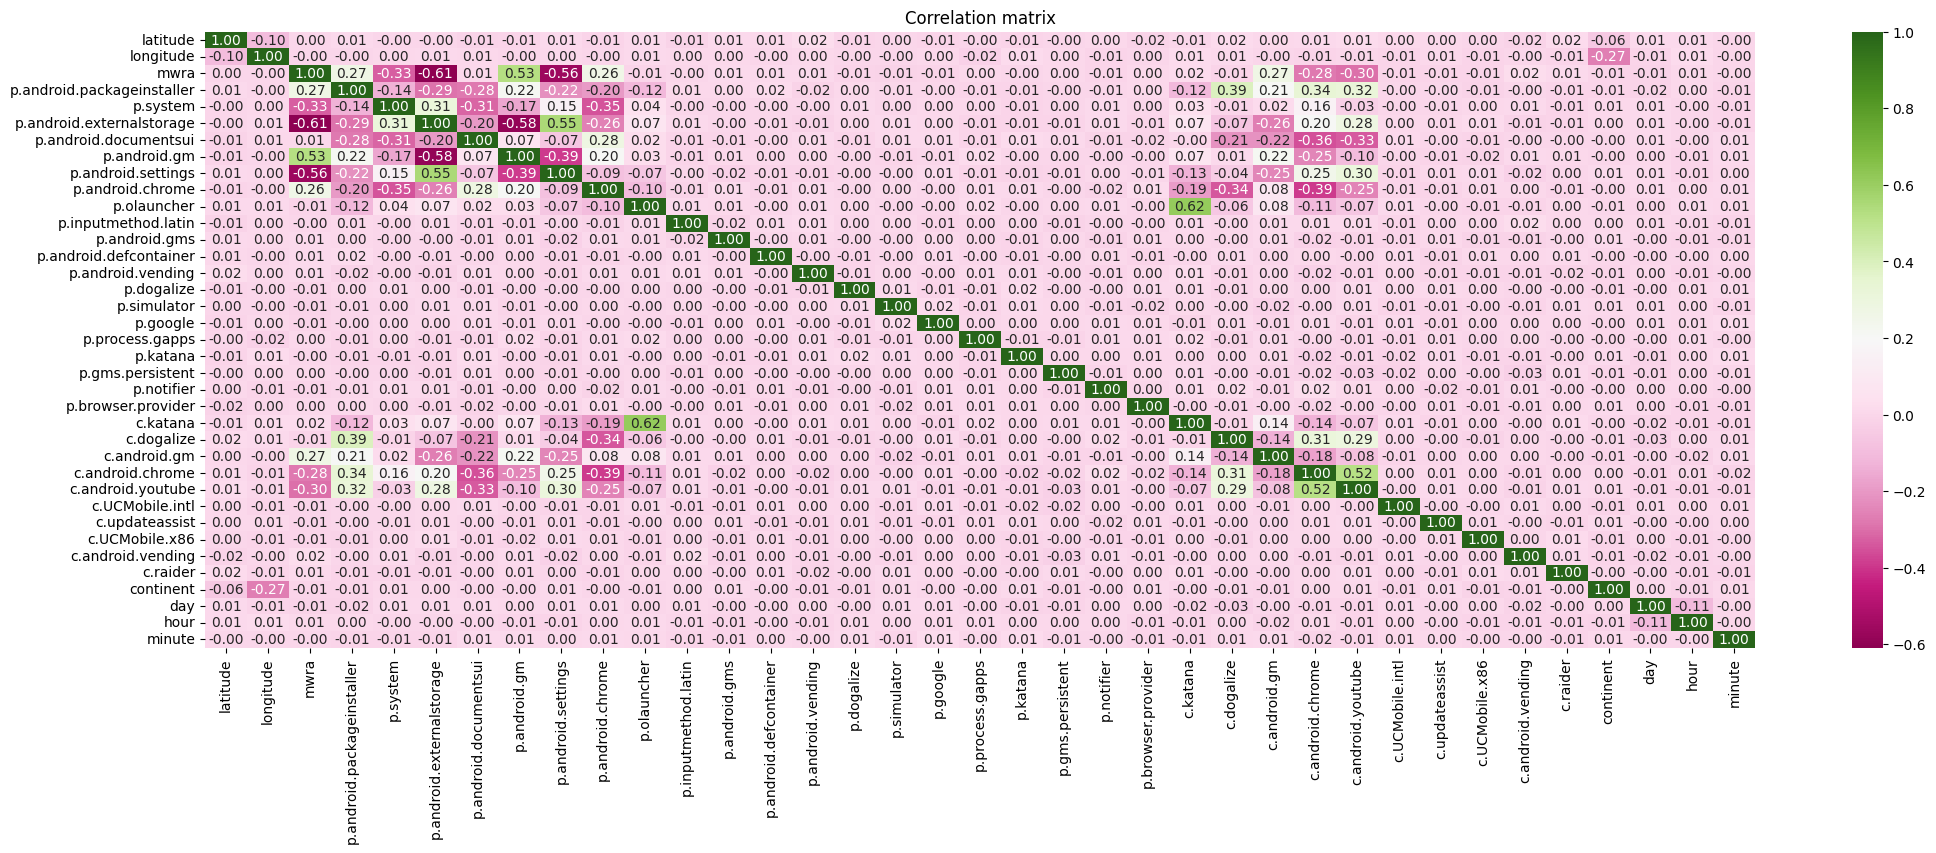

In [79]:
numeric_cols = train_data.select_dtypes(include=[np.number, np.datetime64])
corr_matrix = numeric_cols.corr()
plt.figure(figsize=(25, 8))
sns.heatmap(corr_matrix, fmt='.2f', annot=True, cmap='PiYG')
plt.title('Correlation matrix')
plt.show()

##Attibutes grouping

Як ми поміти з першої фази різні атрибути мають різні дистрибуції, тому ми вирішили їх поділити на групи на основі подібності їх дистрибуцій.

Це зроблено перед використанням технік для трансформування та скелінгу, оскільки деякі з цих технік підходять краще для нормальних дистрибуцій, в той час як інші краще підходять для інших.

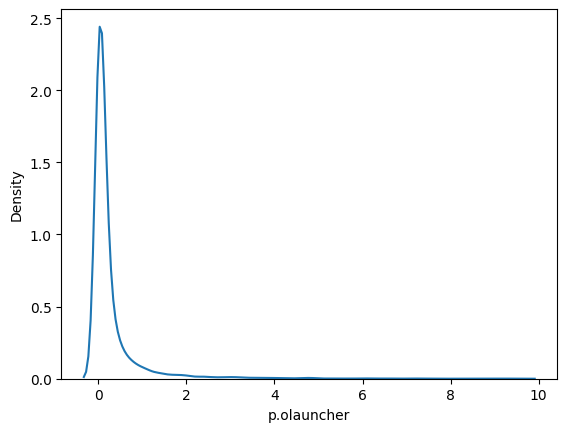

In [83]:
sns.kdeplot(data=train_data['p.olauncher'])
plt.show()

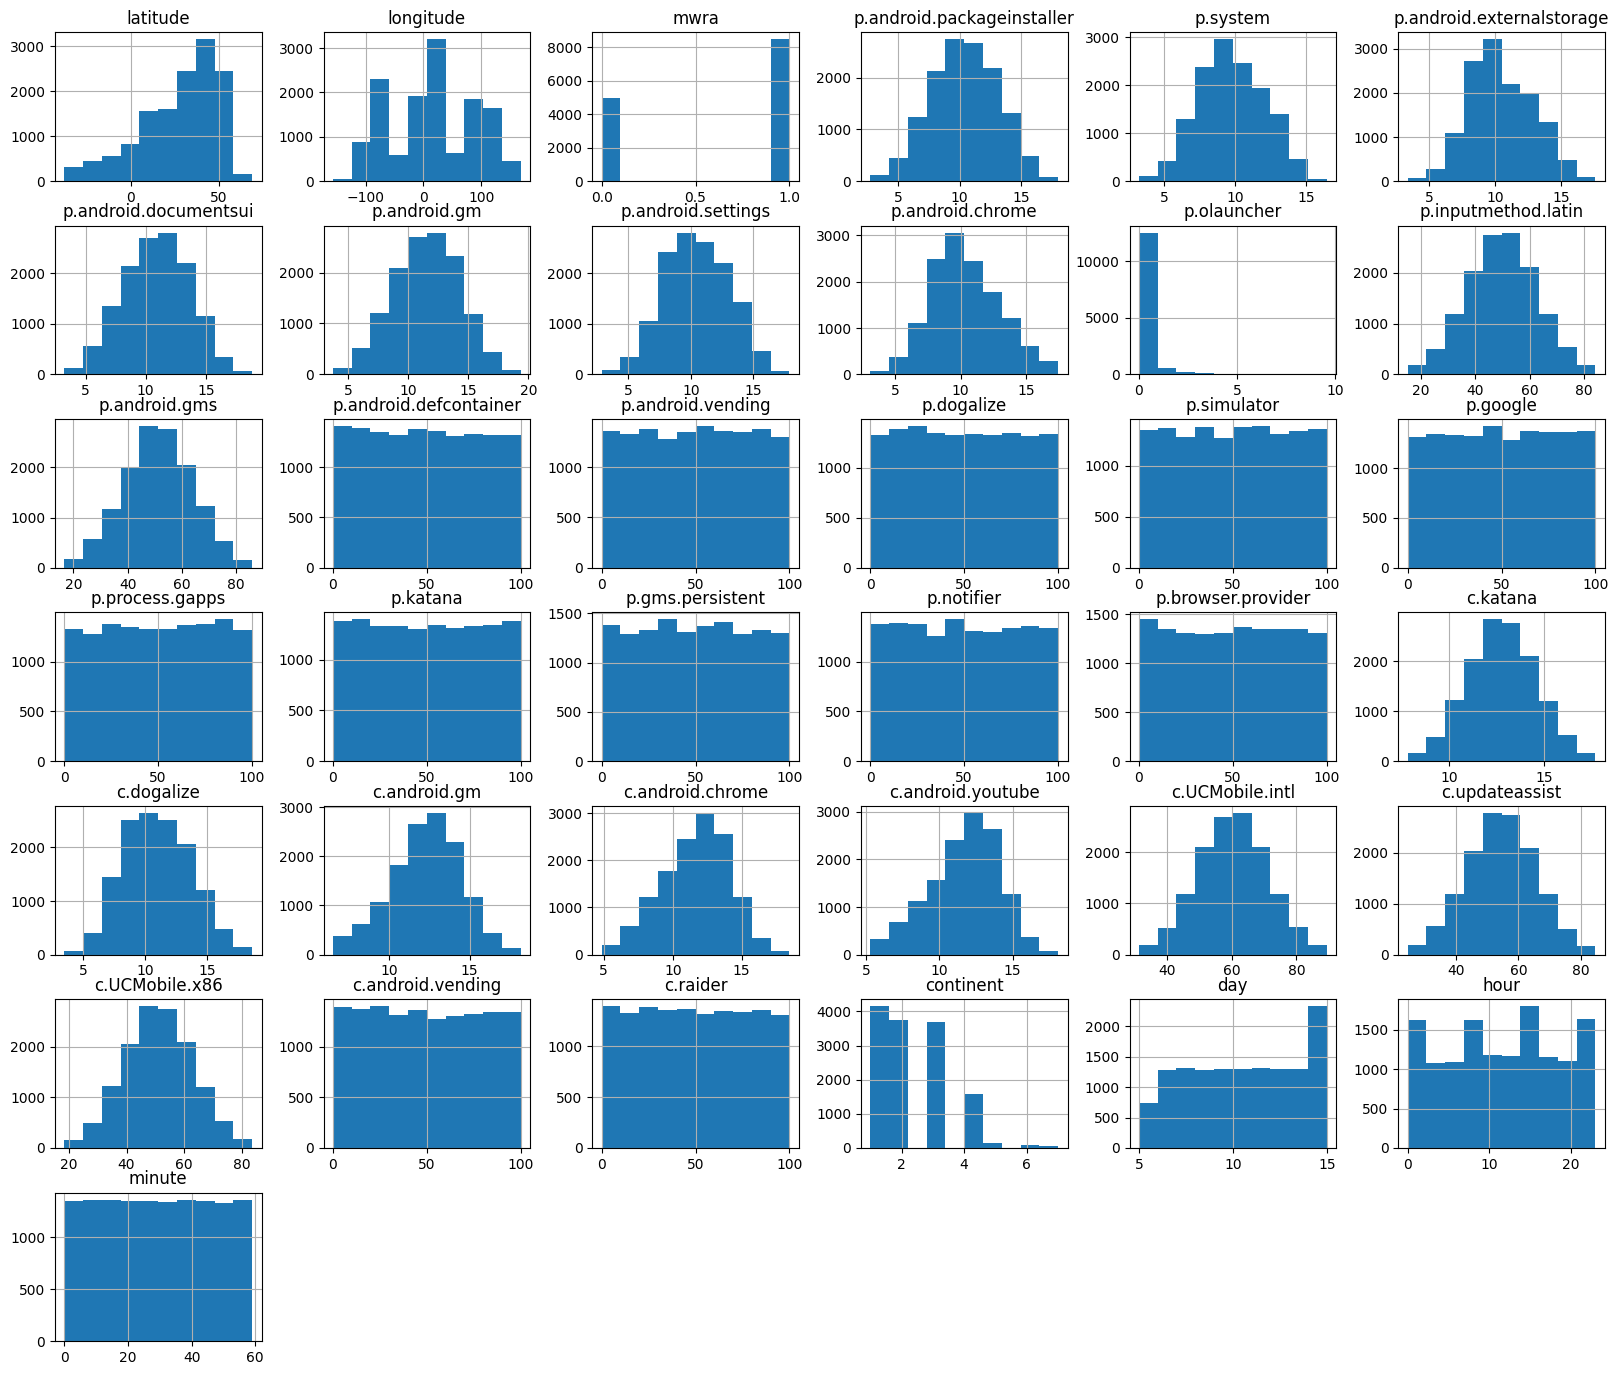

In [84]:
merged_data.hist(figsize=(20, 17))
plt.show()